![](images/EscUpmPolit_p.gif "UPM")

# Kaggle Challenge
## Loan Approval Prediction - New York
El reto consiste en aplicar algoritmos de Machine Learning para predecir la emisión de créditos a un cliente en función de un dataset de entrada para el entrenamiento correspondiente.

El dataset está formado por los siguientes campos:

- id # Text # Identifier of the data instance
- LoanNr_ChkDgt # Text # Identifier of the loan petition
- Name # Text # Borrower name
- City # Text # Borrower city
- State # Text # Borrower state
- Bank # Text # Bank name
- BankState # Text # Bank state
- ApprovalDate # Date/Time # Date SBA commitment issued
- ApprovalFY # Text # Fiscal year of commitment
- NoEmp # Number # Number of business employees
- NewExist # Text # 1 = Existing business, 2 = New business
- CreateJob # Number # Number of jobs created
- RetainedJob # Number # Number of jobs retained
- FranchiseCode # Text # Franchise code, (00000 or 00001) = No franchise
- UrbanRural # Text # 1 = Urban, 2 = rural, 0 = undefined
- RevLineCr # Text # Revolving line of credit: Y = Yes, N = No
- LowDoc # Text # LowDoc Loan Program: Y = Yes, N = No
- DisbursementDate # Date/Time # Disbursement date
- DisbursementGross # Currency # Amount disbursed
- BalanceGross # Currency # Gross amount outstanding
- Accept # Text # Loan approval status. 0 = not approved, 1 = approved


## 1. Importar datos

Para iniciar, se establecen las librerias a utilizar y luego se importan los datos desde el csv usando pandas. Se definen tres dataframes:
- train, contiene la información para el entrenamiento
- test, contiene la información para la predicción

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Training and test spliting
from sklearn.model_selection import train_test_split, KFold

# Estimators
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

# Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test_nolabel.csv')
train.head()

C:\Users\Usuario\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,b353a0b461c,3354343008,"TOGETHER GARGOYLES, INC.",BROOKLYN,NY,JPMORGAN CHASE BANK NATL ASSOC,NY,21-Dec-88,1989,20,...,0,0,0,0,N,N,30-Apr-89,"$350,000.00",$0.00,1
1,cca24bbcc48,2349745003,LAWRENCE K. ALTHISER DBA LARRY,HARTWICK,NY,CITIZENS BANK NATL ASSOC,RI,23-Mar-07,2007,3,...,1,4,0,2,N,N,30-Apr-07,"$35,000.00",$0.00,1
2,e60644381ce,6007284009,TAAMEER CONSTRUCTION INC,BROOKLYN (BOROUGH OF NEW YORK),NY,JPMORGAN CHASE BANK NATL ASSOC,IL,9-Jan-03,2003,5,...,0,5,1,1,0,N,31-Jan-03,"$50,000.00",$0.00,1
3,ffca41a2760,6047703002,"CENTRAL CONTROL SYSTEMS, INC.",SYRACUSE,NY,MANUFACTURERS & TRADERS TR CO,NY,10-Nov-93,1994,25,...,0,0,1,0,N,N,31-Jan-94,"$190,000.00",$0.00,1
4,79e48255003,6590164004,METRO SALON,ROCHESTER,NY,MANUFACTURERS & TRADERS TR CO,NY,14-Aug-03,2003,6,...,0,0,1,1,0,Y,30-Sep-03,"$30,000.00",$0.00,1


De acuerdo a los datos mostrados, se intentará intuir las variables asociadas a la predicción de la aceptación de conseción del crédito teniendo en cuenta lo siguiente:
- ApprovalDate y DisbursementDate, ambas determinan la fecha en que la SBA ha aceptado la solicitud y la fecha en que ha concedido el préstamo. Se podría calcular la diferencia entre ellas.
- NoEmp, la cantidad de empleados puede determinar que tan grande o pequeña es la empresa.
- NewExist, si es una empresa que recién esta empezando su actividad podría afectar la concesión del préstamo.
- CreateJob, si se han creado fuentes de empleo puede ser un indicador del crecimiento de la empresa.
- RetainedJob, representa la cantidad de empleos a tiempo completo existentes al momento de hacer la solicitud y que se mantendrán en caso de conseguir la aprobación.
- RevLineCr, representa el hecho de que tan pronto como se pague la deuda, la empresa puede volver a pedir prestado hasta su límite de crédito sin pasar por otro proceso de aprobación de préstamo.
- LowDoc, de ser verdadero significa que el SBA promete un procesamiento rápido (para montos inferiores a $150,000).
- DisbursementGross, la cantidad que se esta solicitando es importante en conjunto con el resto de parámetros para poder determinar la aprobación del préstamo.
- Accept, el campo más importante porque indica si se ha cedido o no el préstamo.

En la siguiente sección, se revisa cada columna para determinar su utilidad o no para la predicción.

##  2. Limpieza de datos

Se debe eliminar campos irrelevantes o no necesarios. Para esto se analizan los datos numéricos, revisando si hay datos faltantes o nulos, para así completarlos, y/o eliminar columnas no necesarias. Luego se efectúa el mismo procedimiento con los no numéricos.

In [3]:
train.info()

# Revisando duplicados
print("*****************************************************")
print(train.duplicated().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40385 entries, 0 to 40384
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 40385 non-null  object 
 1   LoanNr_ChkDgt      40385 non-null  int64  
 2   Name               40382 non-null  object 
 3   City               40385 non-null  object 
 4   State              40385 non-null  object 
 5   Bank               40340 non-null  object 
 6   BankState          40338 non-null  object 
 7   ApprovalDate       40385 non-null  object 
 8   ApprovalFY         40385 non-null  object 
 9   NoEmp              40385 non-null  int64  
 10  NewExist           40378 non-null  float64
 11  CreateJob          40385 non-null  int64  
 12  RetainedJob        40385 non-null  int64  
 13  FranchiseCode      40385 non-null  int64  
 14  UrbanRural         40385 non-null  int64  
 15  RevLineCr          40250 non-null  object 
 16  LowDoc             403

Se observa que la mayoría de columnas son no numéricas y no se tienen duplicados, por lo que no se elimina ninguna fila. Por otro lado, existen 40385 filas pero en ciertas columnas hay datos con información nula.

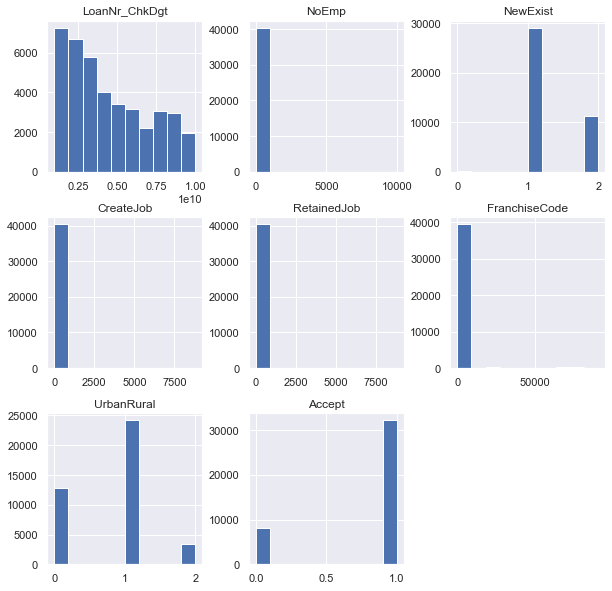

In [4]:
# Ver la distribución de cada columna
train.hist(figsize=(10,10))
plt.show()

A primera vista, parece ser que se tienen sesgos en algunas de las columnas, como NoEmp, RetainedJob, CreateJob y FranchiseCode. Se analizará más adelante este comportamiento.

### 2.1. Revisión de datos cuantitativos

In [5]:
# Ver las estadísticas de las columnas numéricas
train.describe()

,LoanNr_ChkDgt,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,Accept
count,4.038500e+04,40385.000000,40378.000000,40385.000000,40385.000000,40385.000000,40385.00000,40385.000000
mean,4.459565e+09,9.485750,1.279013,4.273666,7.128191,1218.894342,0.76885,0.796360
std,2.539048e+09,54.872591,0.451107,151.989529,152.156119,8647.991363,0.59020,0.402709
min,1.000655e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.276314e+09,2.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,3.804294e+09,4.000000,1.000000,0.000000,1.000000,1.000000,1.00000,1.000000
75%,6.409913e+09,9.000000,2.000000,1.000000,5.000000,1.000000,1.00000,1.000000
max,9.995413e+09,9999.000000,2.000000,8800.000000,8800.000000,91110.000000,2.00000,1.000000


In [6]:
# Ver aquellos atributos numéricos con valores nulos
train.select_dtypes(include=['float64', 'int64']).isnull().sum()

LoanNr_ChkDgt    0
NoEmp            0
NewExist         7
CreateJob        0
RetainedJob      0
FranchiseCode    0
UrbanRural       0
Accept           0
dtype: int64

Se tiene que la única columna con valores nulos es **NoEmp** y se confirman los sesgos en **NoEmp, CreateJob, RetainedJob y FranchiseCode** ya que el 75% de sus datos se acumulan en valores muy por debajo de sus valores máximos.

### Columna LoanNr_ChkDgt

Se revisa el atributo y se determina que al ser un identificador, no aporta a la predicción. Además, se verifica obteniendo la cantidad de valores únicos, siendo este el total de filas del dataframe. Por lo tanto, se elimina esta columna.

In [7]:
print("Valores únicos del atributo LoanNr_ChkDgt:", len(train.LoanNr_ChkDgt.unique()))
train.drop(['LoanNr_ChkDgt'], axis=1, inplace=True)

Valores únicos del atributo LoanNr_ChkDgt: 40385


### Columna NoEmp

Se nota que este atributo se encuentra sesgado ya que la mayor parte de sus valores se acumulan en nueve empleados, lo que se corrobora con sus estadísticas, donde el 75% de sus filas acumulan esta cantidad de empleados. Por lo tanto, se puede reemplazar los outliers por un valor de diez que representa que todos aquellos datos tienen más de nueve empleados.

<AxesSubplot:>

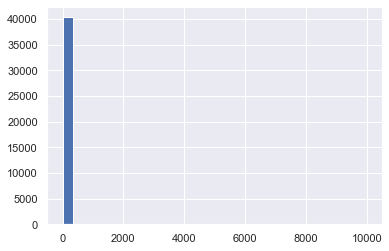

In [8]:
train['NoEmp'].hist(bins=30, range=(0, train['NoEmp'].max()))

<AxesSubplot:>

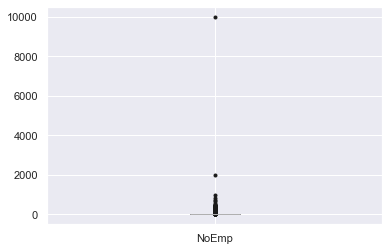

In [9]:
train.boxplot(column='NoEmp', return_type='axes', sym='k.')

In [10]:
print("*****************************************************")
print("La cantidad de valores mayores a 2000 empleados es:", train.NoEmp.loc[train.NoEmp > 2000].count())
print("La mediana es:", train.NoEmp.median())
print("*****************************************************")
train.sort_values('NoEmp', ascending=False).head(5)

*****************************************************
La cantidad de valores mayores a 2000 empleados es: 1
La mediana es: 4.0
*****************************************************


,id,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
15476,dabc1f56760,BRADLEY I. & LINDA M. AULIN,BATH,NY,FIVE STAR BANK,NY,9-Jul-98,1998,9999,1.0,0,0,1,0,N,N,30-Apr-00,"$200,000.00",$0.00,0
28706,9892325b49c,"ZAMIN, INC.",GREAT NECK,NY,"CITIBANK, N.A.",SD,6-Apr-92,1992,1981,1.0,0,0,1,0,N,N,31-Jul-92,"$318,750.00",$0.00,1
22648,7d96998cfb4,"WAYNE'S GIFTS ,INC.",CANANDAIGUA,NY,MANUFACTURERS & TRADERS TR CO,NY,13-Dec-95,1996,1000,2.0,0,0,1,0,N,Y,31-Jul-96,"$100,000.00",$0.00,1
31154,4f4f3f0094e,JOHN C. MANDEL SECURITY BUREAU,BRONX,NY,BUSINESS INITIATIVE CORP OF NE,NY,22-Jun-00,2000,827,1.0,12,815,1,1,N,N,17-Oct-01,"$394,000.00",$0.00,1
17427,1da084c41ed,AMERICAN CV LLC,GANSEVOORT,NY,MANUFACTURERS & TRADERS TR CO,NY,2-Jul-01,2001,750,2.0,4,0,1,1,Y,N,31-Dec-01,"$66,173.00",$0.00,1


Se observa que existen algunos pocos valores con muchos empleados, se intenta interpolar para ver el resultado.

In [11]:
train['NoEmpFilled'] = train['NoEmp'].interpolate()
train['NoEmpFilled'].describe()

count    40385.000000
mean         9.485750
std         54.872591
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max       9999.000000
Name: NoEmpFilled, dtype: float64

A pesar de haber interpolado, el resultado parece seguir sesgado, entonces reemplazamos aquellos valores mayores al tercer cuartil con la mediana.

In [12]:
train.drop(['NoEmpFilled'], axis=1, inplace=True)
train.loc[train.NoEmp > 9, 'NoEmp'] = train.NoEmp.median()
train['NoEmp'].describe()

count    40385.000000
mean         3.487929
std          1.933589
min          0.000000
25%          2.000000
50%          4.000000
75%          4.000000
max          9.000000
Name: NoEmp, dtype: float64

<AxesSubplot:xlabel='NoEmp'>

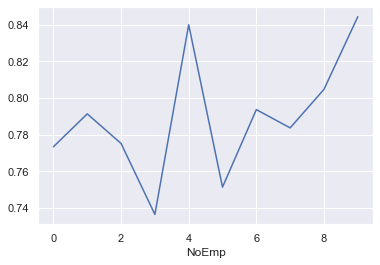

In [13]:
train.groupby('NoEmp').Accept.mean().plot()

### Columna NewExist

Tal como se observó en el train.describe(), este atributo posee valores nulos, se decide reemplazarlos con la mediana ya que es una buena práctica.

In [14]:
train['NewExist'].fillna(train.NewExist.median(), inplace=True)

NewExist
0.0       47
1.0    29025
2.0    11313
dtype: int64

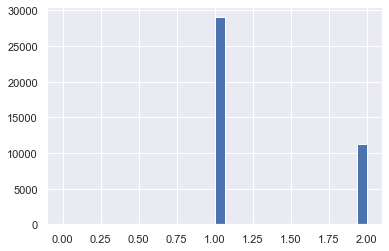

In [15]:
train['NewExist'].hist(bins=30, range=(0, train['NewExist'].max()))
train.groupby('NewExist').size()

Al ver los resultados anteriores, se tienen datos erróneos, ya que para el atributo en cuestión se estableció que unicamente puede tomar los valores 1 y 2; entonces, se reemplazan los valores donde existe el 0 por lel que más se repite, en este caso por 1.

<AxesSubplot:>

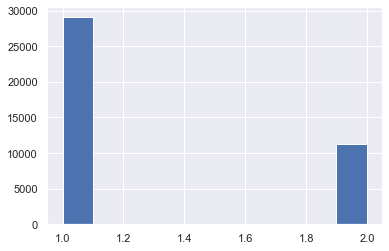

In [16]:
train.loc[train['NewExist'] == 0, 'NewExist'] = train.NewExist.mode()[0]
train['NewExist'].hist()

### Columna CreateJob

A pesar de que se tienen mayormente valores en cero, y hay una alta varianza, se deja intacto hasta revisar el análisis con el resto de columnas.

*****************************************************
La cantidad de valores con ceros es: 28279
La cantidad de valores con unos es: 3656
La cantidad de valores diferentes de cero y uno es: 8450
*****************************************************


count    40385.000000
mean         4.273666
std        151.989529
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       8800.000000
Name: CreateJob, dtype: float64

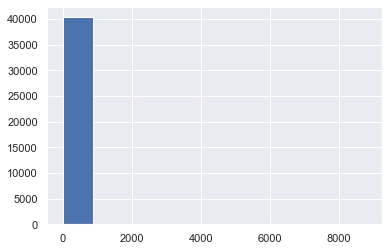

In [17]:
train['CreateJob'].hist()
print("*****************************************************")
print("La cantidad de valores con ceros es:", train.CreateJob.loc[train.CreateJob == 0].count())
print("La cantidad de valores con unos es:", train.CreateJob.loc[train.CreateJob == 1].count())
print("La cantidad de valores diferentes de cero y uno es:", train.CreateJob.loc[train.CreateJob > 1].count())
print("*****************************************************")
train['CreateJob'].describe()

<AxesSubplot:>

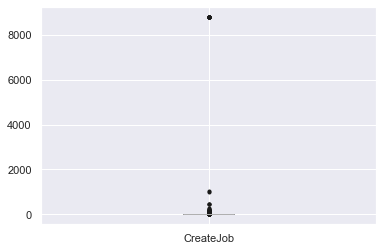

In [18]:
train.boxplot(column='CreateJob', return_type='axes', sym='k.')

<AxesSubplot:xlabel='CreateJob'>

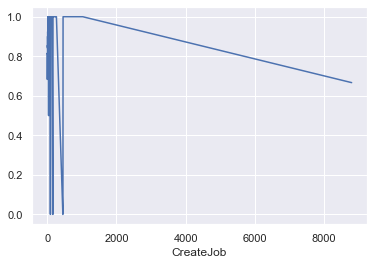

In [19]:
train.groupby('CreateJob').Accept.mean().plot()

La mayoría de valores se concentran en CreateJob menores a 1. A valores altos, la probabilidad de que se acepte el crédito va disminuyendo, pero ésta no llega a cero. Por lo tanto, se deja intacta la columna.

### Columna RetainedJob

*****************************************************
La cantidad de valores con ceros es: 15833
La cantidad de valores con unos es: 4482
La cantidad de valores diferentes de cero y uno es: 20070
*****************************************************


count    40385.000000
mean         7.128191
std        152.156119
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max       8800.000000
Name: RetainedJob, dtype: float64

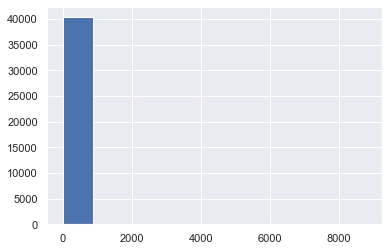

In [20]:
train['RetainedJob'].hist()
print("*****************************************************")
print("La cantidad de valores con ceros es:", train.RetainedJob.loc[train.RetainedJob == 0].count())
print("La cantidad de valores con unos es:", train.RetainedJob.loc[train.RetainedJob == 1].count())
print("La cantidad de valores diferentes de cero y uno es:", train.RetainedJob.loc[train.RetainedJob > 1].count())
print("*****************************************************")
train['RetainedJob'].describe()

<AxesSubplot:xlabel='RetainedJob'>

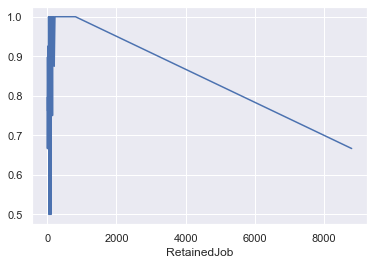

In [21]:
train.groupby('RetainedJob').Accept.mean().plot()

Ocurre algo parecido al caso anterior, hay una alta varianza y el 75% de sus valores es menor o igual a 5 (un valor muy pequeño comparado con el resto), sin embargo, se deja intacto hasta revisar el análisis con el resto de columnas.

### Columna FranchiseCode

Tal como muestra el resultado de train.describe(), esta columna no tiene valores nulos ni duplicados. Además, tiene un sesgo muy marcado al tener la mayor parte de sus valores entre 0 y 1 como se observa en la gráfica y en sus estadísticas.

*****************************************************
La cantidad de valores con ceros es: 12084
La cantidad de valores con unos es: 27310
La cantidad de valores diferentes de cero y uno es: 991
*****************************************************


count    40385.000000
mean      1218.894342
std       8647.991363
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max      91110.000000
Name: FranchiseCode, dtype: float64

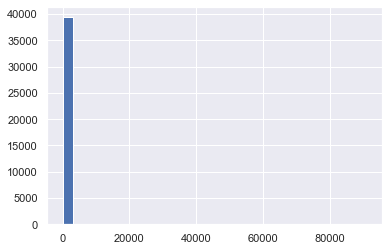

In [22]:
train['FranchiseCode'].hist(bins=30, range=(0, train['FranchiseCode'].max()))
print("*****************************************************")
print("La cantidad de valores con ceros es:", train.FranchiseCode.loc[train.FranchiseCode == 0].count())
print("La cantidad de valores con unos es:", train.FranchiseCode.loc[train.FranchiseCode == 1].count())
print("La cantidad de valores diferentes de cero y uno es:", train.FranchiseCode.loc[train.FranchiseCode > 1].count())
print("*****************************************************")
train.FranchiseCode.describe()

Al ser la cantidad de ceros y unos muy baja, se puede cambiar los valores para eliminar el sesgo dado que esta columna es un codigo asociado al préstamo; y se observa que mejora la información que puede aportar a la predicción.

<AxesSubplot:xlabel='FranchiseCode'>

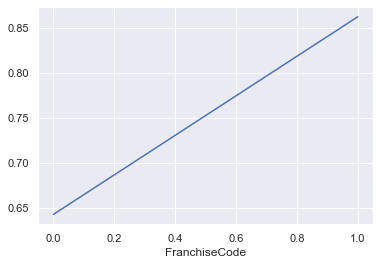

In [23]:
train.loc[train.FranchiseCode > 1, 'FranchiseCode'] = train.FranchiseCode.median()
train.groupby('FranchiseCode').Accept.mean().plot()

### Columna UrbanRural

En este caso, se observa claramente en el histograma que se tienen tres categorías, y al no tener valores nulos ni duplicados se deja intacta.

<AxesSubplot:>

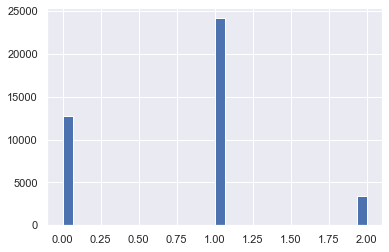

In [24]:
train['UrbanRural'].hist(bins=30, range=(0, train['UrbanRural'].max()))

### 2.2. Revisión de datos cualitativos

In [25]:
train.select_dtypes(include=['object']).describe()

,id,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross
count,40385,40382,40385,40385,40340,40338,40385,40385,40250,40330,40254,40385,40385
unique,40385,37615,2552,1,311,37,6189,87,4,7,2387,11206,1
top,cd329dbcbfb,SUBWAY,NEW YORK,NY,JPMORGAN CHASE BANK NATL ASSOC,NY,8-Nov-04,2005,N,N,31-Oct-05,"$50,000.00",$0.00
freq,1,69,5440,40385,6244,19924,44,3528,17540,36575,512,2907,40385


In [26]:
# Visualizar los valores nulos de los atributos que quedan
train.select_dtypes(include=['object']).isnull().sum()

id                     0
Name                   3
City                   0
State                  0
Bank                  45
BankState             47
ApprovalDate           0
ApprovalFY             0
RevLineCr            135
LowDoc                55
DisbursementDate     131
DisbursementGross      0
BalanceGross           0
dtype: int64

Al revisar los datos no numéricos, se considera que las siguientes columnas no son relevantes al momento de determinar el riesgo ya que aportan solamente información complementaria de la solicitud:
- Name, representa el nombre del usuario. Se tienen 37615 valores únicos con alta complejidad de categorizar.
- City, representa el nombre de la ciudad y al igual que Name, sus 2552 valores únicos no tendrían un alto impacto al categorizarlos.
- State, se tiene un único valor (NY) que tampoco aportaría mayor información a la predicción.
- Bank, en este caso se tienen menos variabilidad pero al ser un nombre propio no aporta información relevante.
- BankState, el mismo caso que State.
- BalanceGross, al igual que State, se tiene un único valor ($0.00) que no aportaría relevancia en la predicción.

Finalmente, se tiene valores nulos en algunas columnas, por lo que se rellenarán más adelante.

In [27]:
train.drop(['Name', 'City', 'State', 'Bank', 'BankState', 'BalanceGross'], axis=1, inplace=True)

### Columna RevLineCr

<AxesSubplot:xlabel='RevLineCr', ylabel='count'>

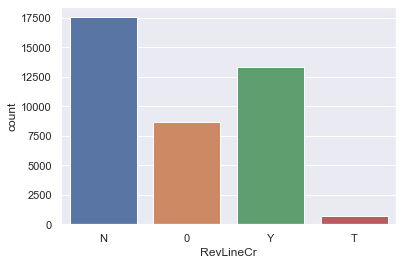

In [28]:
sns.countplot(x='RevLineCr', data=train)

Se observa que para RevLineCr solo se pueden dar dos posibles valores (Y o N) pero se tienen otros (0 y T). Asumiremos, que aquellos que tienen 0 es un N y aquellos con T es un Y. Una vez hecho esto, se rellenan los nulos con el que más se repita, es decir N de acuerdo a lo mostrado por el describe().

<AxesSubplot:xlabel='RevLineCr', ylabel='count'>

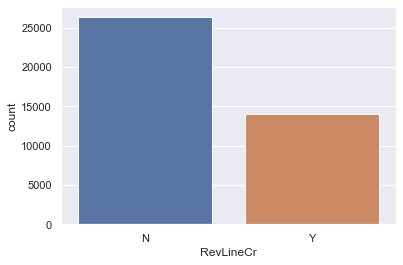

In [29]:
train.loc[train["RevLineCr"] == "0", "RevLineCr"] = 'N'
train.loc[train["RevLineCr"] == "T", "RevLineCr"] = 'Y'
train['RevLineCr'].fillna('N', inplace=True)
sns.countplot(x='RevLineCr', data=train)

### Columna LowDoc

<AxesSubplot:xlabel='LowDoc', ylabel='count'>

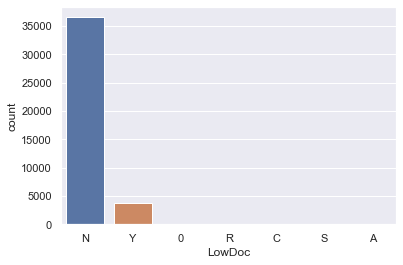

In [30]:
sns.countplot(x='LowDoc', data=train)

Un caso similar ocurre con LowDoc, sin embargo, no podemos asumir cual es Y y N. Por lo tanto, simplemente reemplazamos todos aquellos que no correspondan por el que más se repite.

<AxesSubplot:xlabel='LowDoc', ylabel='count'>

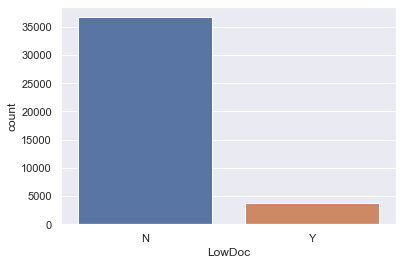

In [31]:
train['LowDoc'].fillna('N', inplace=True)
train.loc[train["LowDoc"] == "0", "LowDoc"] = 'N'
train.loc[train["LowDoc"] == "A", "LowDoc"] = 'N'
train.loc[train["LowDoc"] == "C", "LowDoc"] = 'N'
train.loc[train["LowDoc"] == "R", "LowDoc"] = 'N'
train.loc[train["LowDoc"] == "S", "LowDoc"] = 'N'
sns.countplot(x='LowDoc', data=train)

### Columna DisbursementGross

Este atributo representa el monto del préstamo por lo que lo convertimos a numérico para su análisis.

In [32]:
train["DisbursementGross"] = train["DisbursementGross"].apply(lambda x: x[1:])
train["DisbursementGross"] = train["DisbursementGross"].apply(lambda s: s.strip())
train["DisbursementGross"] = train["DisbursementGross"].replace({',':''}, regex=True)
train.loc[train["DisbursementGross"] == "", "DisbursementGross"] = 0
train["DisbursementGross"] = train["DisbursementGross"].astype(float)
train.DisbursementGross.describe()

count    4.038500e+04
mean     1.469873e+05
std      2.181362e+05
min      0.000000e+00
25%      3.500000e+04
50%      7.500000e+04
75%      1.550000e+05
max      5.000000e+06
Name: DisbursementGross, dtype: float64

<AxesSubplot:>

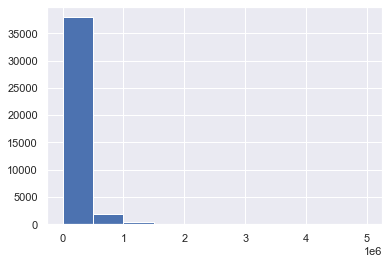

In [33]:
train.DisbursementGross.hist()

Se ve que para el 75%, los valores son menores o iguales a 155000.00. Sin embargo, no se modifica hasta observar su relación con el resto de atributos.

### Columna ApprovalFY

Estos valores representan años, entonces se lo convierte en numérico para su análisis, pero al intentarlo, salta un error debido a que se tienen valores con caracteres. Se corrigen estos valores.

In [34]:
train_cp = train.copy()
train_cp["ApprovalFY"] = train_cp["ApprovalFY"].astype(str)
train_cp["ApprovalFY"] = train_cp["ApprovalFY"].apply(lambda x: x[:4])
train_cp["ApprovalFY"] = train_cp["ApprovalFY"].astype(np.int64)
train = train_cp
train.ApprovalFY.describe()

count    40385.000000
mean      2001.670125
std          5.782541
min       1965.000000
25%       1997.000000
50%       2003.000000
75%       2006.000000
max       2014.000000
Name: ApprovalFY, dtype: float64

<AxesSubplot:>

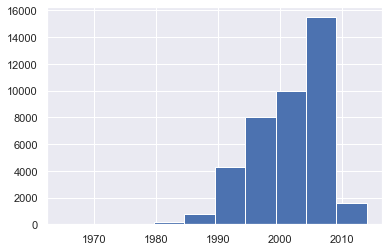

In [35]:
train.ApprovalFY.hist()

<AxesSubplot:>

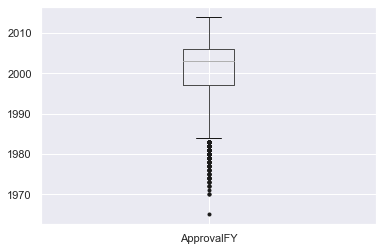

In [36]:
train.boxplot(column='ApprovalFY', return_type='axes', sym='k.')

In [37]:
train.loc[train_cp.ApprovalFY <= 1985].ApprovalFY.count()

300

Una vez aplicado el cambio, aunque se tiene una distribución asimétrica, no se hace ninguna alteración ya que se considera que esta no afectaría a la predicción al tenerse una alta cantidad (300 valores) de outliers.

### Columnas ApprovalDate y DisbursementDate

Estos atributos representan las fechas de aprobación y conseción del préstamo, respectivamente. Se transforman al tipo de dato fecha para su análisis. Cabe destacar que en DisbursementDate hay valores nulos, los cuales dejaremos en blanco y después de la conversión, se lo reemplaza por la mediana.

In [38]:
train['ApprovalDate'] = train['ApprovalDate'].astype(str)
train['DisbursementDate'] = train['DisbursementDate'].astype(str)
train_cp = train.copy()
train_cp["ApprovalDate"] = train_cp["ApprovalDate"].apply(lambda date: datetime.strptime(date, "%d-%b-%y"))
train_cp["DisbursementDate"] = train_cp["DisbursementDate"].apply(lambda date: datetime.strptime(date, "%d-%b-%y") if (date!="nan") else '')
train_cp.loc[:, ['ApprovalDate', 'DisbursementDate']]

,ApprovalDate,DisbursementDate
0,1988-12-21,1989-04-30
1,2007-03-23,2007-04-30
2,2003-01-09,2003-01-31
3,1993-11-10,1994-01-31
4,2003-08-14,2003-09-30
...,...,...
40380,1997-05-15,1997-06-03
40381,2009-10-07,2009-10-07
40382,2005-10-13,2006-04-30
40383,2006-04-10,2006-05-31


In [39]:
# Revisar valores nulos
train_cp.DisbursementDate.fillna(train_cp.DisbursementDate.mode()[0], inplace=True)

<AxesSubplot:>

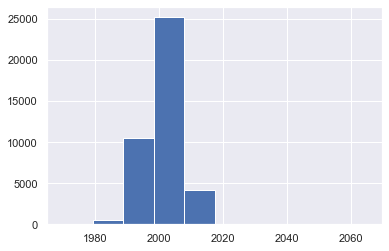

In [40]:
train_cp.ApprovalDate.hist()

<AxesSubplot:>

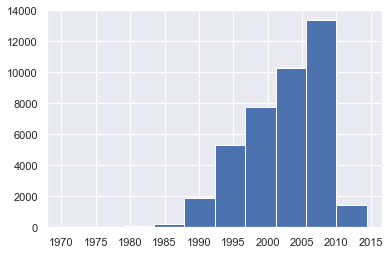

In [41]:
train_cp.DisbursementDate.hist()

Text(0, 0.5, 'DisbursementDate')

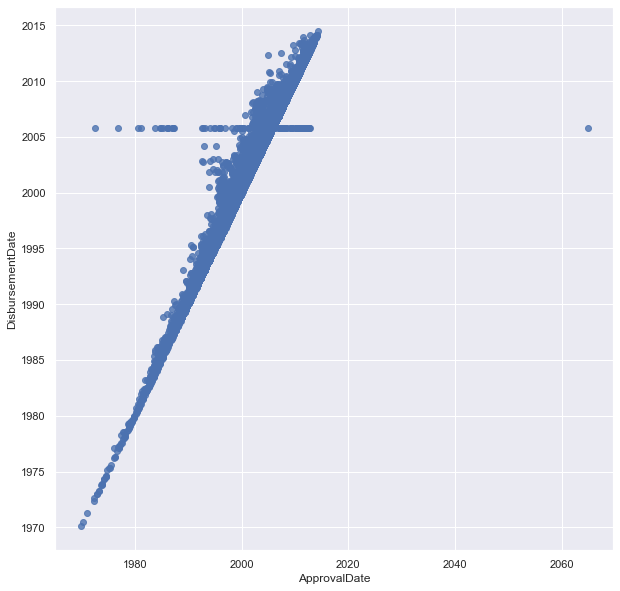

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(x=train_cp.ApprovalDate, y=train_cp.DisbursementDate, alpha= 0.8)
ax.set_xlabel('ApprovalDate')
ax.set_ylabel('DisbursementDate')

Tal parece, que las fechas se encuentras relacionadas. Para una mejor visión, se calcula el periodo de tiempo que transcurre desde que se aprueba el préstamo hasta que se desembolsa.

In [43]:
train_cp.insert(1, 'Period', train_cp.DisbursementDate - train_cp.ApprovalDate)
train_cp.Period.describe()

count                          40385
mean     130 days 18:49:36.451652842
std      298 days 18:04:42.717537252
min            -21577 days +00:00:00
25%                 31 days 00:00:00
50%                 62 days 00:00:00
75%                134 days 00:00:00
max              12214 days 00:00:00
Name: Period, dtype: object

Ahora, se tiene una mejor información, aunque aún hay datos extraños (periodos negativos o muy largos). Se corrige únicamente aquellos valores negativos. Primero se convirte a días (entero) y luego, se reemplazan dichos valores por la mediana.

In [44]:
train_cp["Period"] = train_cp["Period"].apply(lambda t: t/np.timedelta64(1, 'D'))
train_cp["Period"] = train_cp["Period"].astype(np.int64)

In [45]:
print("Cantidad de valores Period menores a 0 días, es:", train_cp.loc[train_cp["Period"] < 0].Period.count())
print("Cantidad de valores Period mayores a 134 días, es:", train_cp.loc[train_cp["Period"] > 134].Period.count())

Cantidad de valores Period menores a 0 días, es: 105
Cantidad de valores Period mayores a 134 días, es: 10067


<AxesSubplot:>

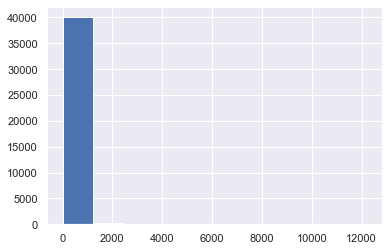

In [46]:
train_cp.loc[train_cp["Period"] < 0, "Period"] = train_cp.Period.median()
train_cp.Period.hist()

Previo al análisis bivariable, se categoriza y convierte cada columna no numérica como se muestra a continuación.

In [47]:
train = train_cp
train.dtypes

id                           object
Period                        int64
ApprovalDate         datetime64[ns]
ApprovalFY                    int64
NoEmp                         int64
NewExist                    float64
CreateJob                     int64
RetainedJob                   int64
FranchiseCode                 int64
UrbanRural                    int64
RevLineCr                    object
LowDoc                       object
DisbursementDate     datetime64[ns]
DisbursementGross           float64
Accept                        int64
dtype: object

In [48]:
train.loc[train["RevLineCr"] == "N", "RevLineCr"] = 0
train.loc[train["RevLineCr"] == "Y", "RevLineCr"] = 1
train.loc[train["LowDoc"] == "N", "LowDoc"] = 0
train.loc[train["LowDoc"] == "Y", "LowDoc"] = 1

train["RevLineCr"] = train["RevLineCr"].astype(np.int64)
train["LowDoc"] = train["LowDoc"].astype(np.int64)
train["DisbursementGross"] = train["DisbursementGross"].astype(np.int64)
train.head()

,id,Period,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,Accept
0,b353a0b461c,130,1988-12-21,1989,4,1.0,0,0,0,0,0,0,1989-04-30,350000,1
1,cca24bbcc48,38,2007-03-23,2007,3,1.0,1,4,0,2,0,0,2007-04-30,35000,1
2,e60644381ce,22,2003-01-09,2003,5,1.0,0,5,1,1,0,0,2003-01-31,50000,1
3,ffca41a2760,82,1993-11-10,1994,4,1.0,0,0,1,0,0,0,1994-01-31,190000,1
4,79e48255003,47,2003-08-14,2003,6,1.0,0,0,1,1,0,1,2003-09-30,30000,1


In [49]:
train.isnull().any()

id                   False
Period               False
ApprovalDate         False
ApprovalFY           False
NoEmp                False
NewExist             False
CreateJob            False
RetainedJob          False
FranchiseCode        False
UrbanRural           False
RevLineCr            False
LowDoc               False
DisbursementDate     False
DisbursementGross    False
Accept               False
dtype: bool

<AxesSubplot:>

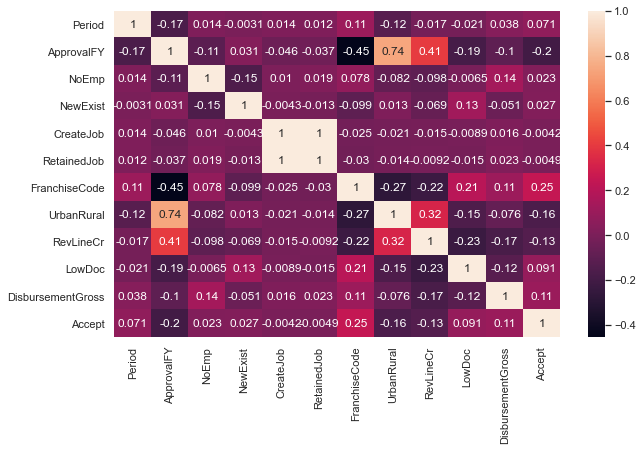

In [50]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), annot=True)

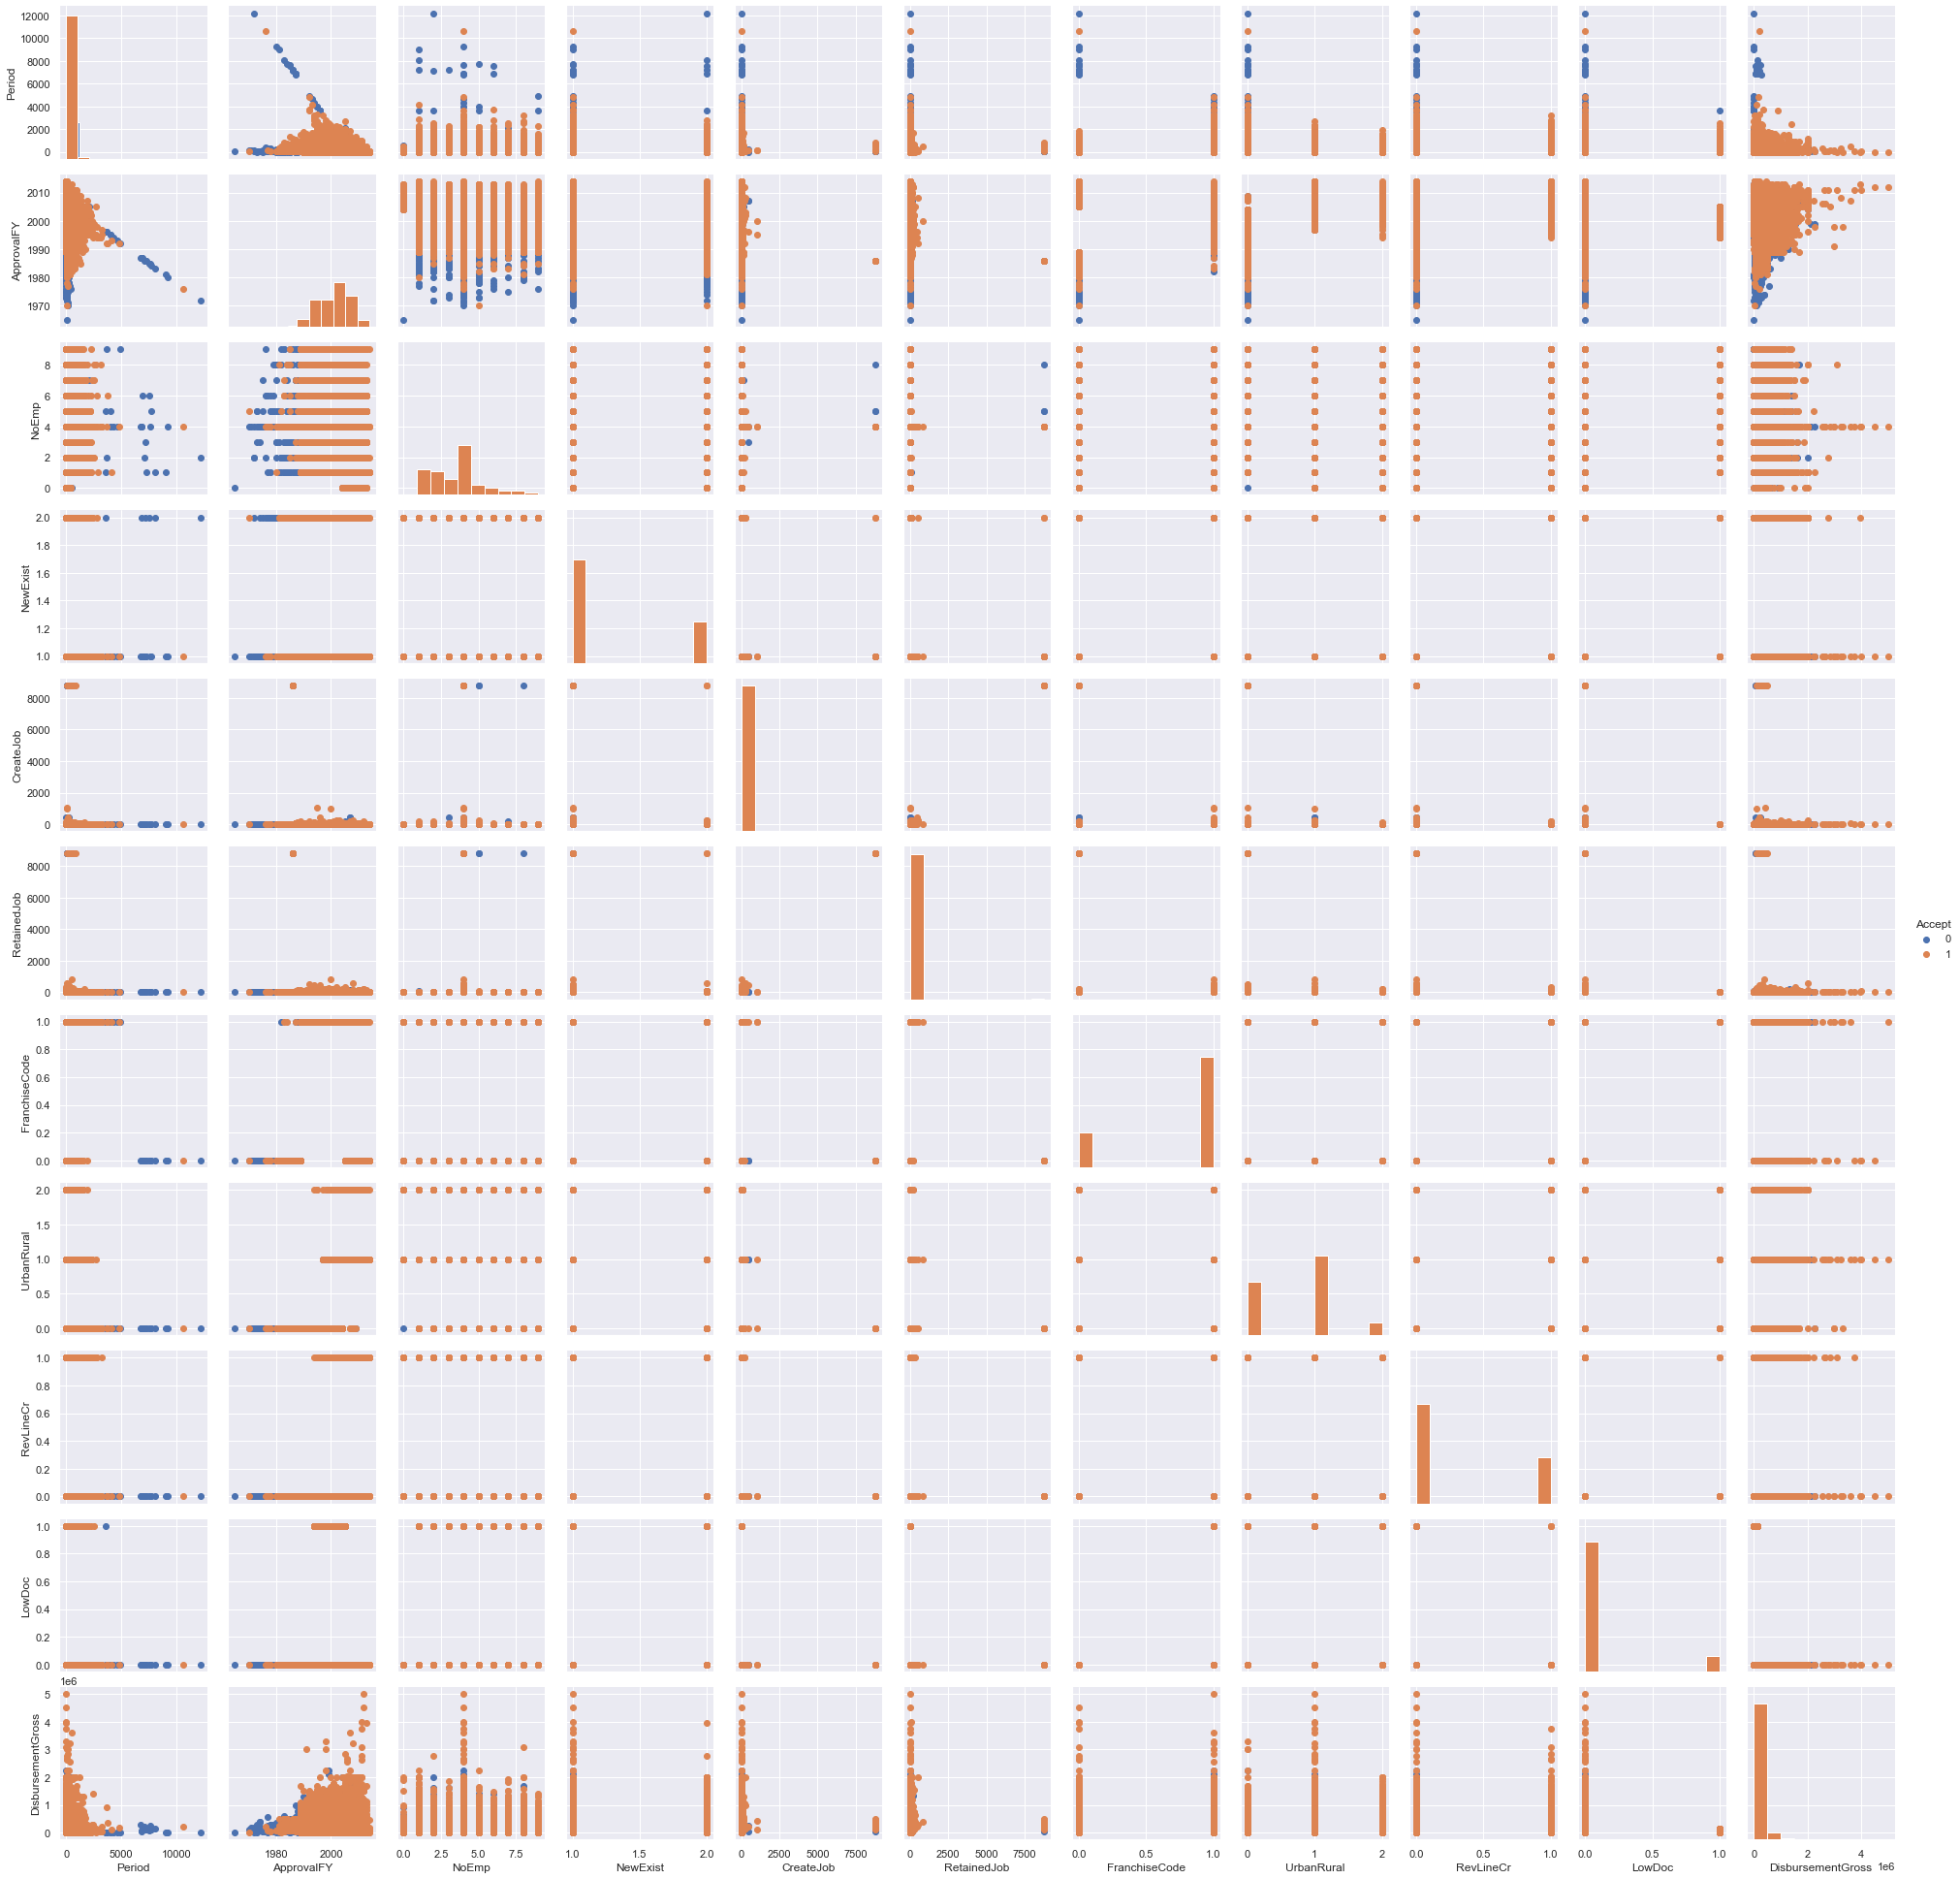

In [51]:
g = sns.PairGrid(train, hue="Accept")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

Se puede notar que el atributo Period calculado presenta poca relación con el resto de atributos. Además, en el gráfico scatter no se aprecia ninguna relación no lineal de importancia con las demás columnas (a excepción de ApprovalFY), por lo tanto, se elimina esta columna, así como DisbursementDate y ApprovalDate, y se queda únicamente con ApprovalFY. Por otro lado, se observa que DisbursementGross se lleva bien con las categóricas RevLineCr, FranchiseCode, UrbanRural y NewExist.

In [52]:
train.drop(['Period', 'DisbursementDate', 'ApprovalDate'], axis=1, inplace=True)

Revisar el detalle entre las categóricas RevLineCr, FranchiseCode, UrbanRural, LowDoc y NewExist con DisbursementGross.

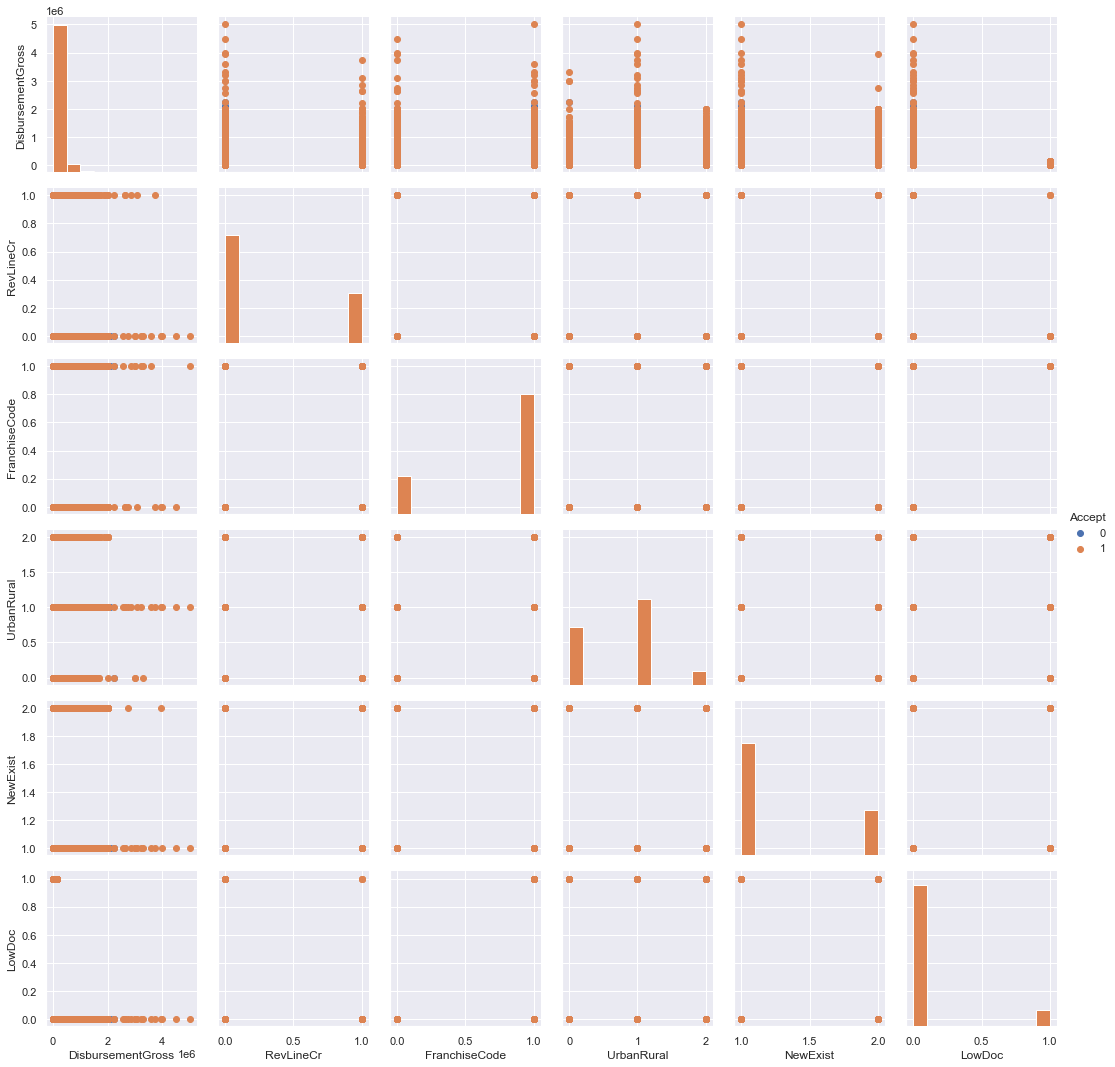

In [53]:
g = sns.PairGrid(train, hue="Accept", vars=['DisbursementGross', 'RevLineCr', 'FranchiseCode', 'UrbanRural', 'NewExist', 'LowDoc'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

Se observa que cada una de las columnas categóricas tienen buena relación con el target. Se revisa sus probabilidades a continuación para confirmarlo.

In [54]:
train.groupby('RevLineCr').Accept.mean()

RevLineCr
0    0.835687
1    0.722559
Name: Accept, dtype: float64

In [55]:
train.groupby('FranchiseCode').Accept.mean()

FranchiseCode
0    0.64242
1    0.86209
Name: Accept, dtype: float64

In [56]:
train.groupby('UrbanRural').Accept.mean()

UrbanRural
0    0.922770
1    0.727401
2    0.811030
Name: Accept, dtype: float64

In [57]:
train.groupby('NewExist').Accept.mean()

NewExist
1.0    0.789557
2.0    0.813842
Name: Accept, dtype: float64

In [58]:
train.groupby('LowDoc').Accept.mean()

LowDoc
0    0.784684
1    0.911987
Name: Accept, dtype: float64

Se confirma lo anterior por lo que se mantienen estos atributos. Ahora, se detalla el atributo DisbursementGross.

<AxesSubplot:xlabel='RevLineCr', ylabel='DisbursementGross'>

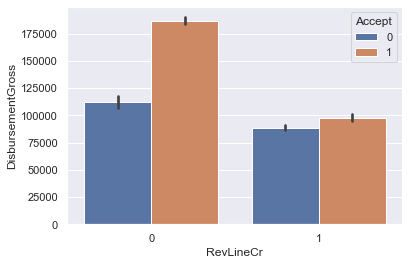

In [59]:
sns.barplot(x='RevLineCr', y='DisbursementGross', hue='Accept', data=train)

<AxesSubplot:xlabel='FranchiseCode', ylabel='DisbursementGross'>

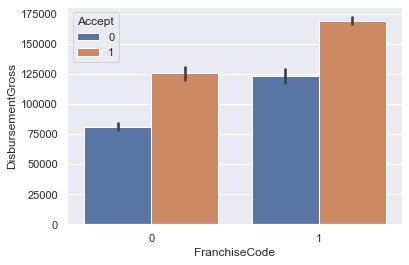

In [60]:
sns.barplot(x='FranchiseCode', y='DisbursementGross', hue='Accept', data=train)

<AxesSubplot:xlabel='UrbanRural', ylabel='DisbursementGross'>

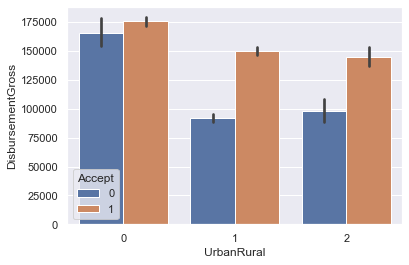

In [61]:
sns.barplot(x='UrbanRural', y='DisbursementGross', hue='Accept', data=train)

<AxesSubplot:xlabel='NewExist', ylabel='DisbursementGross'>

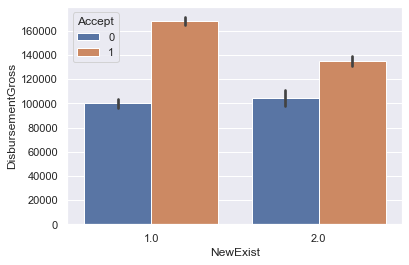

In [62]:
sns.barplot(x='NewExist', y='DisbursementGross', hue='Accept', data=train)

<AxesSubplot:xlabel='LowDoc', ylabel='DisbursementGross'>

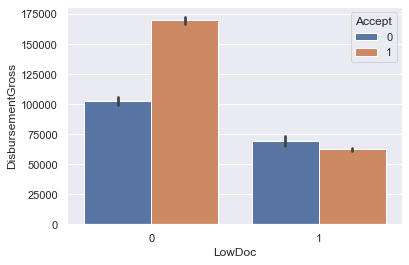

In [63]:
sns.barplot(x='LowDoc', y='DisbursementGross', hue='Accept', data=train)

Efectivamente, se comprueba que DisbursementGross aportaría información relevante para la predicción. Ahora, comprobar que ocurre con NoEmp.

NoEmp    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

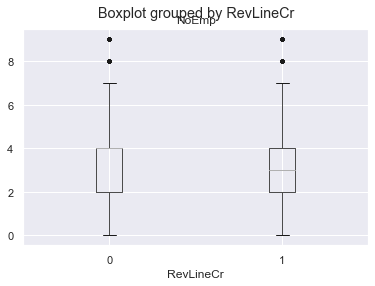

In [64]:
train.boxplot(column='NoEmp', by = 'RevLineCr', return_type='axes', sym='k.')

NoEmp    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

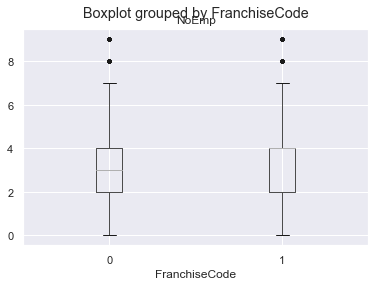

In [65]:
train.boxplot(column='NoEmp', by = 'FranchiseCode', return_type='axes', sym='k.')

NoEmp    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

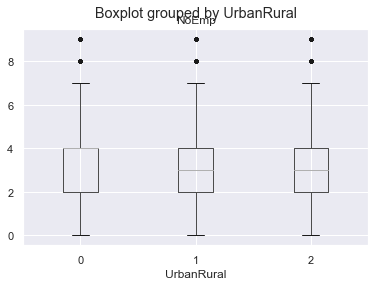

In [66]:
train.boxplot(column='NoEmp', by = 'UrbanRural', return_type='axes', sym='k.')

Se llega a la misma conclusión, por lo que se mantienen estos atributos para la predicción. Ahora, se procede a revisar las columnas CreateJob, RetainedJob y ApprovalFY con las funciones de densidad en relación al target Accept.

Del gráfico inicial, se obtiene que tanto CreateJob como RetainedJob pueden estar relacionada con NewExist y NoEmp. Se prueba lo mismo para ApprovalFY.

<AxesSubplot:xlabel='NewExist', ylabel='CreateJob'>

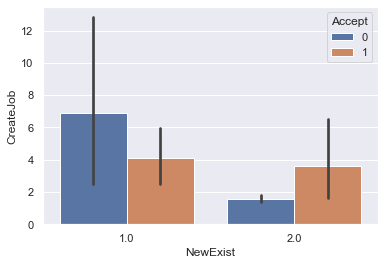

In [67]:
sns.barplot(x='NewExist', y='CreateJob', hue='Accept', data=train)

<AxesSubplot:xlabel='NoEmp', ylabel='CreateJob'>

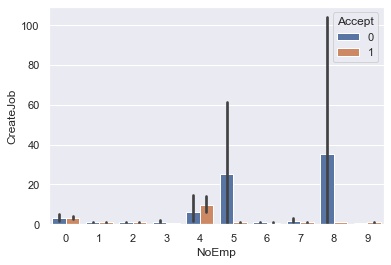

In [68]:
sns.barplot(x='NoEmp', y='CreateJob', hue='Accept', data=train)

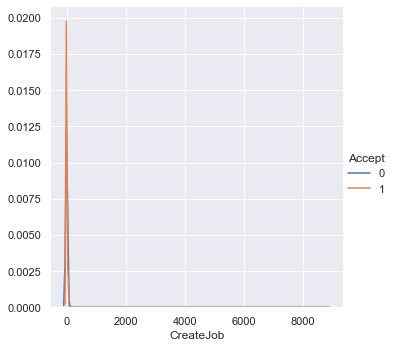

In [69]:
sns.FacetGrid(train, hue="Accept", height=5).map(sns.kdeplot, "CreateJob").add_legend()

No se obtienen conclusiones significativas para mantener este atributo, ya que la relación con los atributos antes mencionados es baja así como la probabilidad de aceptación. También ocurre esto con RetainedJob, tal como se muestra a continuación.

<AxesSubplot:xlabel='NewExist', ylabel='RetainedJob'>

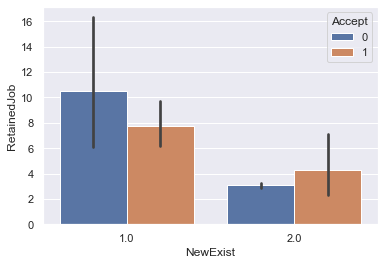

In [70]:
sns.barplot(x='NewExist', y='RetainedJob', hue='Accept', data=train)

<AxesSubplot:xlabel='NoEmp', ylabel='RetainedJob'>

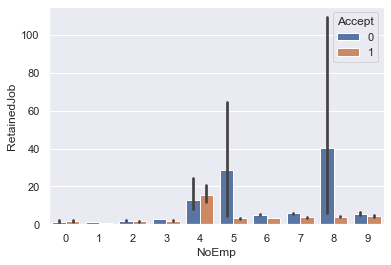

In [71]:
sns.barplot(x='NoEmp', y='RetainedJob', hue='Accept', data=train)

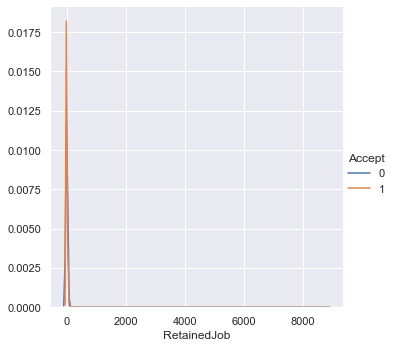

In [72]:
sns.FacetGrid(train, hue="Accept", height=5).map(sns.kdeplot, "RetainedJob").add_legend()

Sin embargo, se determina que ocurre lo contrario con ApprovalFY.

<AxesSubplot:xlabel='NewExist', ylabel='ApprovalFY'>

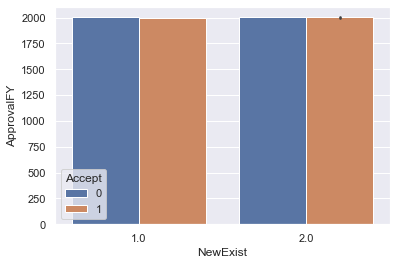

In [73]:
sns.barplot(x='NewExist', y='ApprovalFY', hue='Accept', data=train)

<AxesSubplot:xlabel='NoEmp', ylabel='ApprovalFY'>

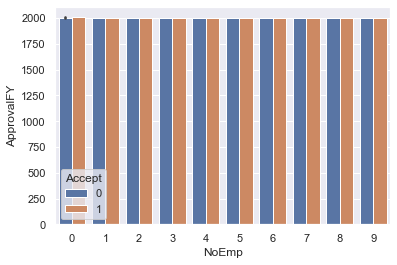

In [74]:
sns.barplot(x='NoEmp', y='ApprovalFY', hue='Accept', data=train)

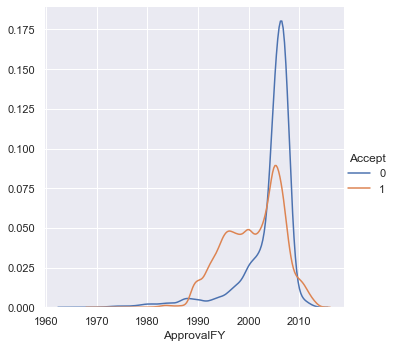

In [75]:
sns.FacetGrid(train, hue="Accept", height=5).map(sns.kdeplot, "ApprovalFY").add_legend()

Antes de determinar una decisión final, se detalla la relación con los atributos categóricos (UrbanRural y LowDoc que son los que mejor probabilidad tienen con el target) por si hubiera alguna información relevante.

<AxesSubplot:xlabel='UrbanRural', ylabel='CreateJob'>

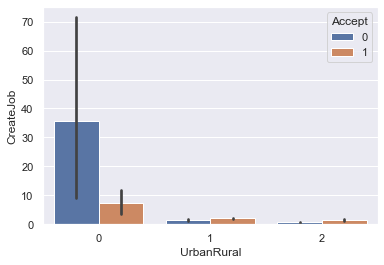

In [76]:
sns.barplot(x='UrbanRural', y='CreateJob', hue='Accept', data=train)

<AxesSubplot:xlabel='UrbanRural', ylabel='RetainedJob'>

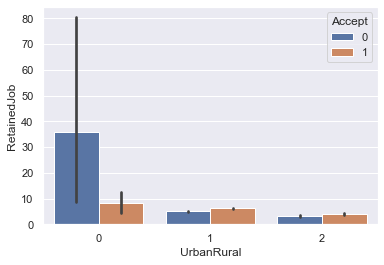

In [77]:
sns.barplot(x='UrbanRural', y='RetainedJob', hue='Accept', data=train)

CreateJob    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

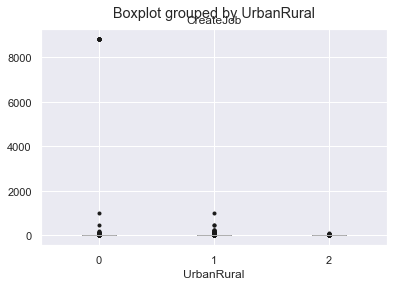

In [78]:
train.boxplot(column='CreateJob', by = 'UrbanRural', return_type='axes', sym='k.')

RetainedJob    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

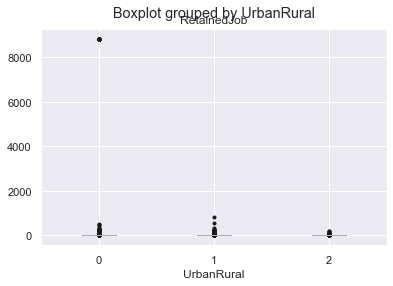

In [79]:
train.boxplot(column='RetainedJob', by = 'UrbanRural', return_type='axes', sym='k.')

<AxesSubplot:xlabel='UrbanRural', ylabel='ApprovalFY'>

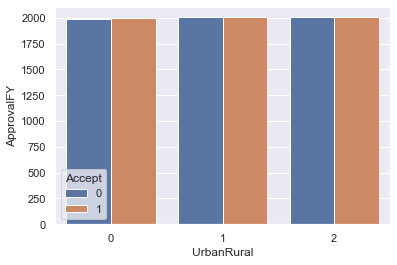

In [80]:
sns.barplot(x='UrbanRural', y='ApprovalFY', hue='Accept', data=train)

<AxesSubplot:xlabel='LowDoc', ylabel='ApprovalFY'>

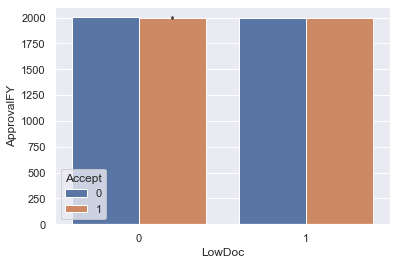

In [81]:
sns.barplot(x='LowDoc', y='ApprovalFY', hue='Accept', data=train)

Finalmente, se toma la decisión de mantener únicamente ApprovalFY.

In [82]:
train.drop(['RetainedJob', 'CreateJob'], axis=1, inplace=True)

Quedando de la siguiente manera el dataset:

In [83]:
train.head()

,id,ApprovalFY,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,Accept
0,b353a0b461c,1989,4,1.0,0,0,0,0,350000,1
1,cca24bbcc48,2007,3,1.0,0,2,0,0,35000,1
2,e60644381ce,2003,5,1.0,1,1,0,0,50000,1
3,ffca41a2760,1994,4,1.0,1,0,0,0,190000,1
4,79e48255003,2003,6,1.0,1,1,0,1,30000,1


In [84]:
train.dtypes

id                    object
ApprovalFY             int64
NoEmp                  int64
NewExist             float64
FranchiseCode          int64
UrbanRural             int64
RevLineCr              int64
LowDoc                 int64
DisbursementGross      int64
Accept                 int64
dtype: object

In [85]:
train.describe()

,ApprovalFY,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,Accept
count,40385.000000,40385.000000,40385.000000,40385.000000,40385.00000,40385.000000,40385.000000,4.038500e+04,40385.000000
mean,2001.670125,3.487929,1.280129,0.700780,0.76885,0.347629,0.091717,1.469873e+05,0.796360
std,5.782541,1.933589,0.449068,0.457922,0.59020,0.476223,0.288630,2.181362e+05,0.402709
min,1965.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000
25%,1997.000000,2.000000,1.000000,0.000000,0.00000,0.000000,0.000000,3.500000e+04,1.000000
50%,2003.000000,4.000000,1.000000,1.000000,1.00000,0.000000,0.000000,7.500000e+04,1.000000
75%,2006.000000,4.000000,2.000000,1.000000,1.00000,1.000000,0.000000,1.550000e+05,1.000000
max,2014.000000,9.000000,2.000000,1.000000,2.00000,1.000000,1.000000,5.000000e+06,1.000000


# 3. Algoritmo ML
En esta sección se aplican varios algoritmos para entrenamiento, siendo uno de ellos el algoritmo Bernoulli Naive Bayes.

## 3.1. Train and test splitting

Se grafica la distribución del target para tener una idea de lo que se puede esperar. Como se observa, se tiene mayormente una cantidad alta de créditos aprobados.

Accept
0     8224
1    32161
dtype: int64


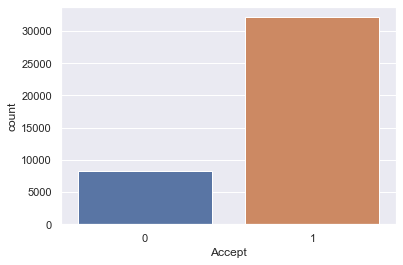

In [86]:
sns.countplot(x='Accept', data=train)
print(train.groupby('Accept').size())

Para equilibrar la distribución, se pueden eliminar cierta cantidad de datos y ver el resultado.

<AxesSubplot:xlabel='Accept', ylabel='count'>

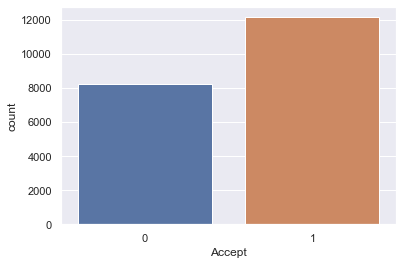

In [87]:
# Se hace una copia para probar
train_cp = train.drop(train.sort_values('Accept', ascending=True).tail(20000).index)
sns.countplot(x='Accept', data=train_cp)

Ahora, se puede decir que se tiene una distribución más equilibrada, lo cual ayudará a tener una mejor predicción.

In [88]:
train = train_cp

x_train_1 = train.drop(['Accept', 'id'], axis=1)
x_train = x_train_1.values
y_train = train['Accept'].values

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=33)

Debido a la distribución que se tiene de los atributos, se va a normalizar para probar si con estos datos se obtiene un mejor resultado.

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

## 3.2. Definir modelos


In [90]:
models = {"Linear SVC": LinearSVC(random_state=42, max_iter=8000), \
          "Nearest Neighbors": KNeighborsClassifier(), \
          "Random Forest": RandomForestClassifier(n_estimators=100), \
          "Bernoulli": BernoulliNB()
         }

## 3.3. Entrenar y evaluar

Como se mencionó anteriormente, se va a realizar el entrenamiento y evaluación con los datos no normalizados primero, y luego con los normalizados. De cada entrenamiento se obtiene la matriz de confusión, el F1_score y la precisión para determinar el mejor algortimo.

In [91]:
# Entrenamiento con el dataframe sin normalizar
i = 0
f1_global = []
for name in models:
    print("Start training models of {}".format(name))
    clf = models[name]
    clf.fit(X_train, Y_train)
    predicted = clf.predict(X_test)
    f1_global.append(f1_score(Y_test, predicted))
    print(confusion_matrix(Y_test, predicted))
    print(classification_report(Y_test, predicted))
    print("F1_score of %s is %s"%(name, f1_global[i]))
    print("Accuracy of %s is %s"%(name, accuracy_score(Y_test, predicted)))
    i+=1
    print("*************************************************************")
print("Global: f1={:.4f}\n".format(np.average(f1_global)))

Start training models of Linear SVC


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[[  94 1998]
 [  63 2942]]
              precision    recall  f1-score   support

           0       0.60      0.04      0.08      2092
           1       0.60      0.98      0.74      3005

    accuracy                           0.60      5097
   macro avg       0.60      0.51      0.41      5097
weighted avg       0.60      0.60      0.47      5097

F1_score of Linear SVC is 0.740591567023285
Accuracy of Linear SVC is 0.5956444967628016
*************************************************************
Start training models of Nearest Neighbors
[[1033 1059]
 [ 744 2261]]
              precision    recall  f1-score   support

           0       0.58      0.49      0.53      2092
           1       0.68      0.75      0.71      3005

    accuracy                           0.65      5097
   macro avg       0.63      0.62      0.62      5097
weighted avg       0.64      0.65      0.64      5097

F1_score of Nearest Neighbors is 0.7149407114624505
Accuracy of Nearest Neighbors is 0.64626250735

Revisando los resultados anteriores, se tiene que los modelos que mejor se ajustan son Random Forest y Bernoulli. Se elige Bernoulli porque posee binariza los atributos permitiendo obtener mejores predicciones.

In [92]:
# Entrenamiento con el dataframe normalizado
i = 0
f1_global = []
for name in models:
    print("Start training models of {}".format(name))
    clf = models[name]
    clf.fit(X_train_scale, Y_train)
    predicted = clf.predict(X_test_scale)
    f1_global.append(f1_score(Y_test, predicted))
    print(confusion_matrix(Y_test, predicted))
    print(classification_report(Y_test, predicted))
    print("F1_score of %s is %s"%(name, f1_global[i]))
    print("Accuracy of %s is %s"%(name, accuracy_score(Y_test, predicted)))
    i+=1
    print("*************************************************************")
print("Global: f1={:.4f}\n".format(np.average(f1_global)))

Start training models of Linear SVC
[[1057 1035]
 [ 710 2295]]
              precision    recall  f1-score   support

           0       0.60      0.51      0.55      2092
           1       0.69      0.76      0.72      3005

    accuracy                           0.66      5097
   macro avg       0.64      0.63      0.64      5097
weighted avg       0.65      0.66      0.65      5097

F1_score of Linear SVC is 0.7245461720599841
Accuracy of Linear SVC is 0.6576417500490485
*************************************************************
Start training models of Nearest Neighbors
[[1213  879]
 [ 747 2258]]
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      2092
           1       0.72      0.75      0.74      3005

    accuracy                           0.68      5097
   macro avg       0.67      0.67      0.67      5097
weighted avg       0.68      0.68      0.68      5097

F1_score of Nearest Neighbors is 0.7352653858677954
Accuracy 

Para el entrenamiento con el dataframe normalizado se tienen mejores resultados, esto es porque se cambia la distribución de los atributos a una media de cero y una desviación de 1. Al igual que el caso anterior, se elige Bernoulli ya que proporciona las mejores métricas del entrenamiento.

## 3.4. Mejorar modelo
Una vez elegido el modelo, se procede a encontrar los mejores hiperparámetros utilizando GridSearchCV que permitan establecer una mejor precisión en la predicción.

In [93]:
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

optBNB = BayesSearchCV(
    BernoulliNB(),
    {
        'alpha': (1e-6, 1e+6, 'log-uniform'),
        'binarize': (1e-6, 1e+1, 'log-uniform'),
        'fit_prior': [True, False]
    },
    n_iter=35,
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
)

En caso de presentar error con la importación de la biblioteca **skopt**, ejecutar el siguiente comando, reiniciar el kernel y volver a ejecutar el notebook.

In [94]:
# conda install -c conda-forge scikit-optimize

Encontrar el mejor modelo usando los datos no normalizados.

In [95]:
optBNB.fit(X_train, Y_train)
print("********************************************")
print("Results for Bernoulli")
print("val. score: %s" % optBNB.best_score_)
print("test score: %s" % optBNB.score(X_test, Y_test))
print("best params: %s" % str(optBNB.best_params_))

********************************************
Results for Bernoulli
val. score: 0.6625455703975613
test score: 0.6539140670982931
best params: OrderedDict([('alpha', 0.0014754176730418205), ('binarize', 0.0034165197604043057), ('fit_prior', True)])


In [96]:
# Evaluar modelo
best_clf = BernoulliNB(alpha=optBNB.best_params_['alpha'], binarize=optBNB.best_params_['binarize'], fit_prior=optBNB.best_params_['fit_prior'])
best_clf.fit(X_train, Y_train)
predicted = best_clf.predict(X_test)
print(confusion_matrix(Y_test, predicted))
print(classification_report(Y_test, predicted))
print("F1_score of is %s"%(f1_score(Y_test, predicted)))
print("Accuracy of is %s"%(accuracy_score(Y_test, predicted)))

[[1032 1060]
 [ 704 2301]]
              precision    recall  f1-score   support

           0       0.59      0.49      0.54      2092
           1       0.68      0.77      0.72      3005

    accuracy                           0.65      5097
   macro avg       0.64      0.63      0.63      5097
weighted avg       0.65      0.65      0.65      5097

F1_score of is 0.7229029217719134
Accuracy of is 0.6539140670982931


Encontrar el mejor modelo usando los datos normalizados.

In [97]:
optBNB.fit(X_train_scale, Y_train)
print("********************************************")
print("Results for Bernoulli")
print("val. score: %s" % optBNB.best_score_)
print("test score: %s" % optBNB.score(X_test_scale, Y_test))
print("best params: %s" % str(optBNB.best_params_))

********************************************
Results for Bernoulli
val. score: 0.6730983704231285
test score: 0.673533451049637
best params: OrderedDict([('alpha', 1e-06), ('binarize', 0.43104061763315), ('fit_prior', False)])


In [98]:
# Evaluar modelo
best_clf_n = BernoulliNB(alpha=optBNB.best_params_['alpha'], binarize=optBNB.best_params_['binarize'], fit_prior=optBNB.best_params_['fit_prior'])
best_clf_n.fit(X_train_scale, Y_train)
predicted = best_clf_n.predict(X_test_scale)
print(confusion_matrix(Y_test, predicted))
print(classification_report(Y_test, predicted))
print("F1_score of is %s"%(f1_score(Y_test, predicted)))
print("Accuracy of is %s"%(accuracy_score(Y_test, predicted)))

[[1464  628]
 [1036 1969]]
              precision    recall  f1-score   support

           0       0.59      0.70      0.64      2092
           1       0.76      0.66      0.70      3005

    accuracy                           0.67      5097
   macro avg       0.67      0.68      0.67      5097
weighted avg       0.69      0.67      0.68      5097

F1_score of is 0.702963227418779
Accuracy of is 0.673533451049637


En ambos casos, se obtienen buenos resultados F1_score, pero con algo en particular, la matriz de confusión arroja valores verdaderos positivos nulos para el caso en que no se aprueba el crédito y una gran cantidad de falsos negativos. Quizás esto se pueda mejorar.

## 3.4. Predección final

Una vez obtenido el mejor modelo, se procede a aplicar todo el tratamiento/pre-procesado al dataframe **test** para ejecutar la predicción sobre estos datos.

In [99]:
test_clean = test.copy()

test_clean.drop(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Bank', 'BankState', 'BalanceGross', 'DisbursementDate', 'ApprovalDate', 'RetainedJob', 'CreateJob'], axis=1, inplace=True)

test_clean.loc[test_clean.NoEmp > 9, 'NoEmp'] = test_clean.NoEmp.median()

test_clean['NewExist'].fillna(test_clean.NewExist.median(), inplace=True)
test_clean.loc[test_clean['NewExist'] == 0, 'NewExist'] = test_clean.NewExist.mode()[0]

test_clean.loc[test_clean.FranchiseCode > 1, 'FranchiseCode'] = test_clean.FranchiseCode.median()

test_clean['LowDoc'].fillna('N', inplace=True)
test_clean.loc[test_clean["LowDoc"] == "0", "LowDoc"] = 'N'
test_clean.loc[test_clean["LowDoc"] == "A", "LowDoc"] = 'N'
test_clean.loc[test_clean["LowDoc"] == "C", "LowDoc"] = 'N'
test_clean.loc[test_clean["LowDoc"] == "R", "LowDoc"] = 'N'
test_clean.loc[test_clean["LowDoc"] == "S", "LowDoc"] = 'N'

test_clean.loc[test_clean["RevLineCr"] == "0", "RevLineCr"] = 'N'
test_clean.loc[test_clean["RevLineCr"] == "T", "RevLineCr"] = 'Y'
test_clean['RevLineCr'].fillna('N', inplace=True)

test_clean["DisbursementGross"] = test_clean["DisbursementGross"].apply(lambda x: x[1:])
test_clean["DisbursementGross"] = test_clean["DisbursementGross"].apply(lambda s: s.strip())
test_clean["DisbursementGross"] = test_clean["DisbursementGross"].replace({',':''}, regex=True)
test_clean.loc[test_clean["DisbursementGross"] == "", "DisbursementGross"] = 0
test_clean["DisbursementGross"] = test_clean["DisbursementGross"].astype(float)

test_clean["ApprovalFY"] = test_clean["ApprovalFY"].astype(str)
test_clean["ApprovalFY"] = test_clean["ApprovalFY"].apply(lambda x: x[:4])
test_clean["ApprovalFY"] = test_clean["ApprovalFY"].astype(np.int64)

test_clean.loc[test_clean["RevLineCr"] == "N", "RevLineCr"] = 0
test_clean.loc[test_clean["RevLineCr"] == "Y", "RevLineCr"] = 1
test_clean.loc[test_clean["LowDoc"] == "N", "LowDoc"] = 0
test_clean.loc[test_clean["LowDoc"] == "Y", "LowDoc"] = 1

test_clean["RevLineCr"] = test_clean["RevLineCr"].astype(np.int64)
test_clean["LowDoc"] = test_clean["LowDoc"].astype(np.int64)
test_clean["DisbursementGross"] = test_clean["DisbursementGross"].astype(np.int64)

In [100]:
test_clean.dtypes

id                    object
ApprovalFY             int64
NoEmp                  int64
NewExist             float64
FranchiseCode          int64
UrbanRural             int64
RevLineCr              int64
LowDoc                 int64
DisbursementGross      int64
dtype: object

In [101]:
test_clean.head()

,id,ApprovalFY,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross
0,63ef5dfc62f,1998,1,2.0,1,0,0,1,35000
1,65ee0569c05,1994,4,1.0,1,0,0,0,145000
2,19058f4da52,2002,4,1.0,1,1,1,0,52174
3,a0f1299afe4,2006,6,2.0,0,1,1,0,194316
4,e47da0be9fc,2004,3,1.0,1,1,1,0,75000


Una vez hecha la limpieza y pre-procesamiento, se continua con la predicción, no sin antes ejecutar la normalización de los atributos de test_clean; ya que se había escogido el modelo Bernoulli con normalización del dataframe.

In [102]:
ids = test_clean['id'].values
x_test_1 = test_clean.drop(['id'], axis=1)
x_test = x_test_1.values
x_test_scale = StandardScaler().fit_transform(x_test)
predicted = best_clf_n.predict(x_test_scale)

## 4. Entrega

Se convierte el array a dataframe y posteriormente a csv para la entrega.

In [103]:
submission = pd.DataFrame(predicted.astype(int), index=ids, columns=['Accept'])
submission.index.name="id"
submission.to_csv(r'./submission.csv', index=True)